# T1 and T2 star Mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pydicom import dcmread
from skimage.filters import gaussian
from einops import rearrange

## SVD compressed dictionary based mapping

The idea of SVD compressed dictionary based mapping was first proposed by McGivney, Debra F., et al in 2014 [1]. Here we implemented the algorithm for T1 and T2 star mapping. The only difference between the original algorithm and our implementation is that we calculated the pearson correlation coefficient instead of vector production to find the best match between the dictionary and the measured signal.

Here the number of singular values used for compression is decided by the threshold, which is the percentage of the total energy of the singular values. 

[1] McGivney, D.F., Pierre, E., Ma, D., Jiang, Y., Saybasili, H., Gulani, V. and Griswold, M.A., 2014. SVD compression for magnetic resonance fingerprinting in the time domain. IEEE transactions on medical imaging, 33(12), pp.2311-2322.

In [2]:
def SVD_dict_fit(img_list, t_list, dict_keys, dict, threshold=0.99, preprocessed=True):

    if preprocessed:
        img = gaussian(img_list, sigma=0.8, channel_axis=0)
    else:
        img = img_list.copy().astype(np.float64)
    img /= img.max()

    t, h ,w = img.shape
    img_flatten = rearrange(img, "t h w -> t (h w)")

    U,S,VH = np.linalg.svd(dict, full_matrices=False)

    k_feature = int(np.argwhere(np.cumsum(S/S.sum())>threshold).flatten().min()+1)
    print('Eigen number: ', k_feature)

    VH_k = VH[:k_feature]
    U_k = U[:,:k_feature]

    T1_dict_k = dict@VH_k.T

    img_flatten_k = img_flatten.T@VH_k.T

    map = (img_flatten_k @ T1_dict_k.T*k_feature-np.outer(img_flatten_k.sum(axis=1),T1_dict_k.sum(axis=1)))/(np.sqrt(np.outer(k_feature*(img_flatten_k**2).sum(axis=1)-(img_flatten_k.sum(axis=1))**2,k_feature*(T1_dict_k**2).sum(axis=1)-(T1_dict_k.sum(axis=1))**2)))
    map_max = np.argmax(map, axis=1)

    map_result = dict_keys[map_max]
    map_img = rearrange(map_result, "(h w) -> h w", h=h, w=w)
    return map_img

## T1 Mapping

dict size:  (22500,)


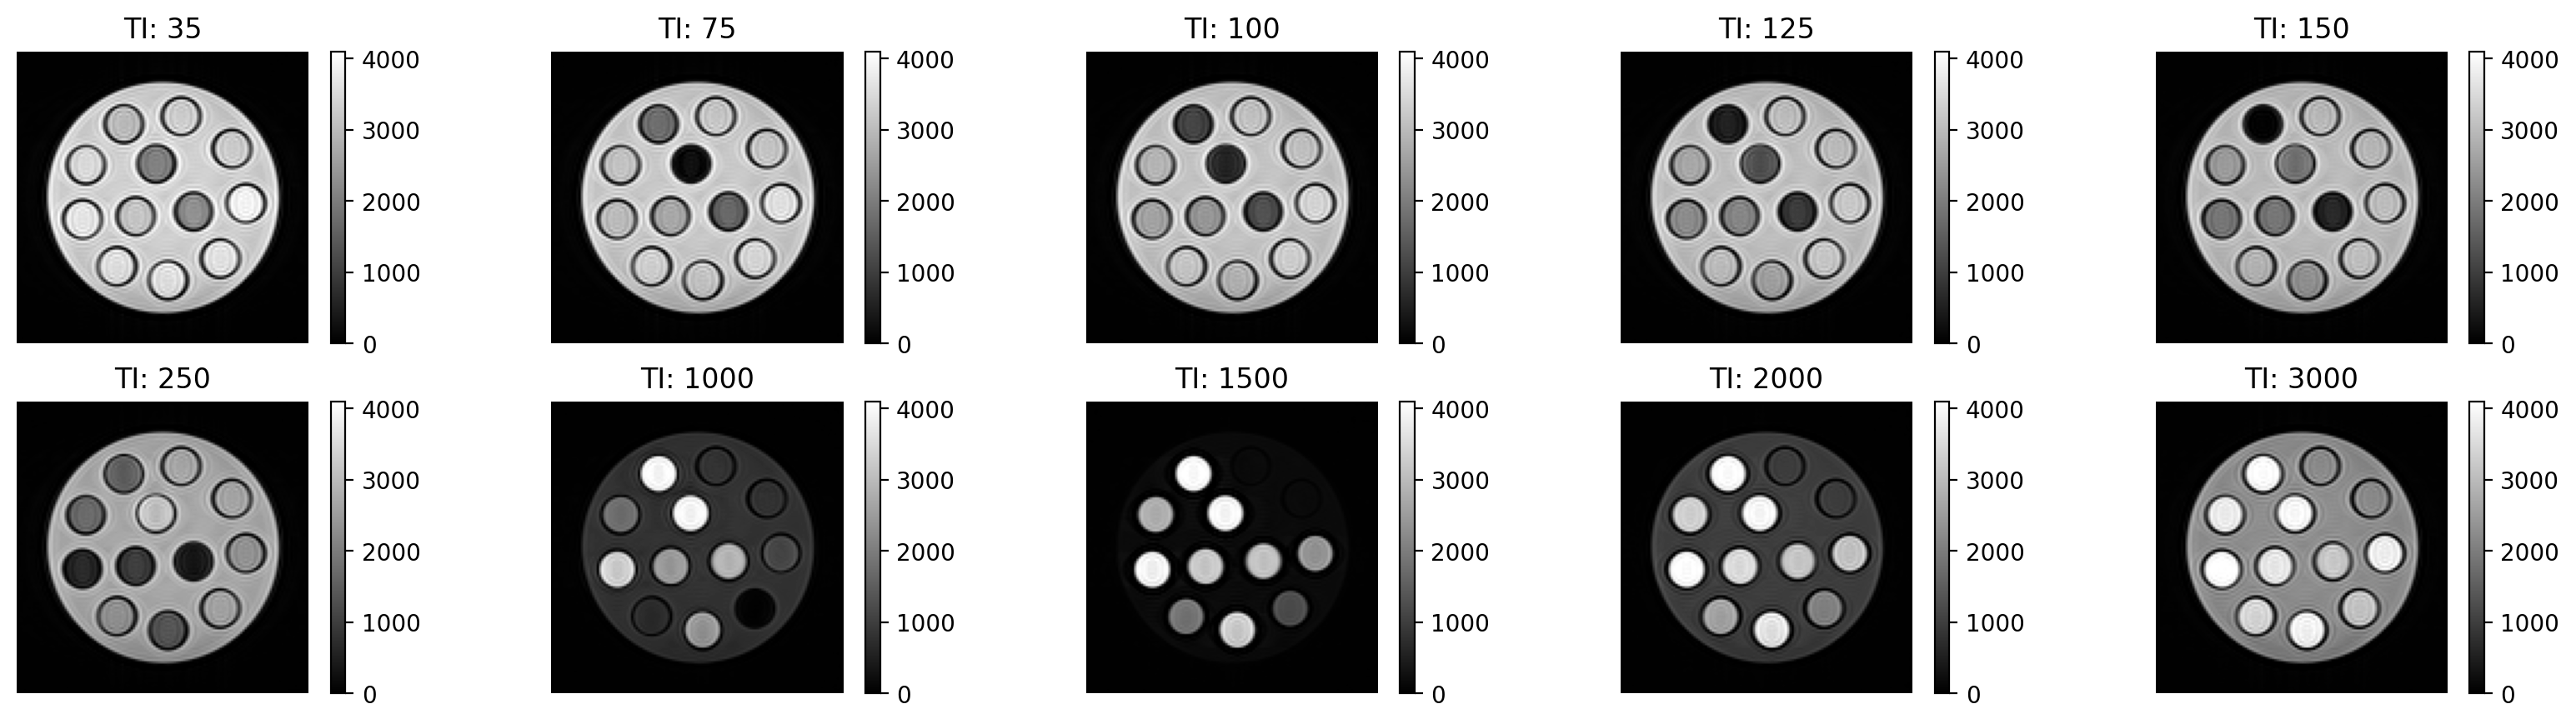

In [3]:
# Load T1 data
data_path = "T1 IR"
TI_list = []
img_list = []
for data in os.listdir(data_path):
    if 'tse' in data:
        TI = int(data.split('_')[-1])
        img = dcmread(os.path.join(data_path, data, '00001.dcm')).pixel_array
        TI_list.append(TI)
        img_list.append(img)

TI_list = np.asarray(TI_list)
img_list = np.asarray(img_list)
TI_list_idx = np.argsort(TI_list)
TI_list = TI_list[TI_list_idx]
img_list = img_list[TI_list_idx]

# Generate T1 dict
T1_keys = np.arange(50,2300,0.1)
print("dict size: ", T1_keys.shape)
T1_dict = []
for TI in TI_list:
    T1_dict.append(np.abs((1-2*np.exp(-TI/T1_keys))))
T1_dict = np.asarray(T1_dict).T

plt.figure(figsize=(20,5),dpi=200)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(img_list[i], cmap='gray')
    plt.clim(img_list.min(), img_list.max())
    plt.axis('off')
    plt.title("TI: "+str(TI_list[i]))
    plt.colorbar()

Eigen number:  7


C:\Users\HP\AppData\Local\Temp\ipykernel_12680\1330246560.py:24: RuntimeWarning: invalid value encountered in true_divide
  map = (img_flatten_k @ T1_dict_k.T*k_feature-np.outer(img_flatten_k.sum(axis=1),T1_dict_k.sum(axis=1)))/(np.sqrt(np.outer(k_feature*(img_flatten_k**2).sum(axis=1)-(img_flatten_k.sum(axis=1))**2,k_feature*(T1_dict_k**2).sum(axis=1)-(T1_dict_k.sum(axis=1))**2)))


Eigen number:  7


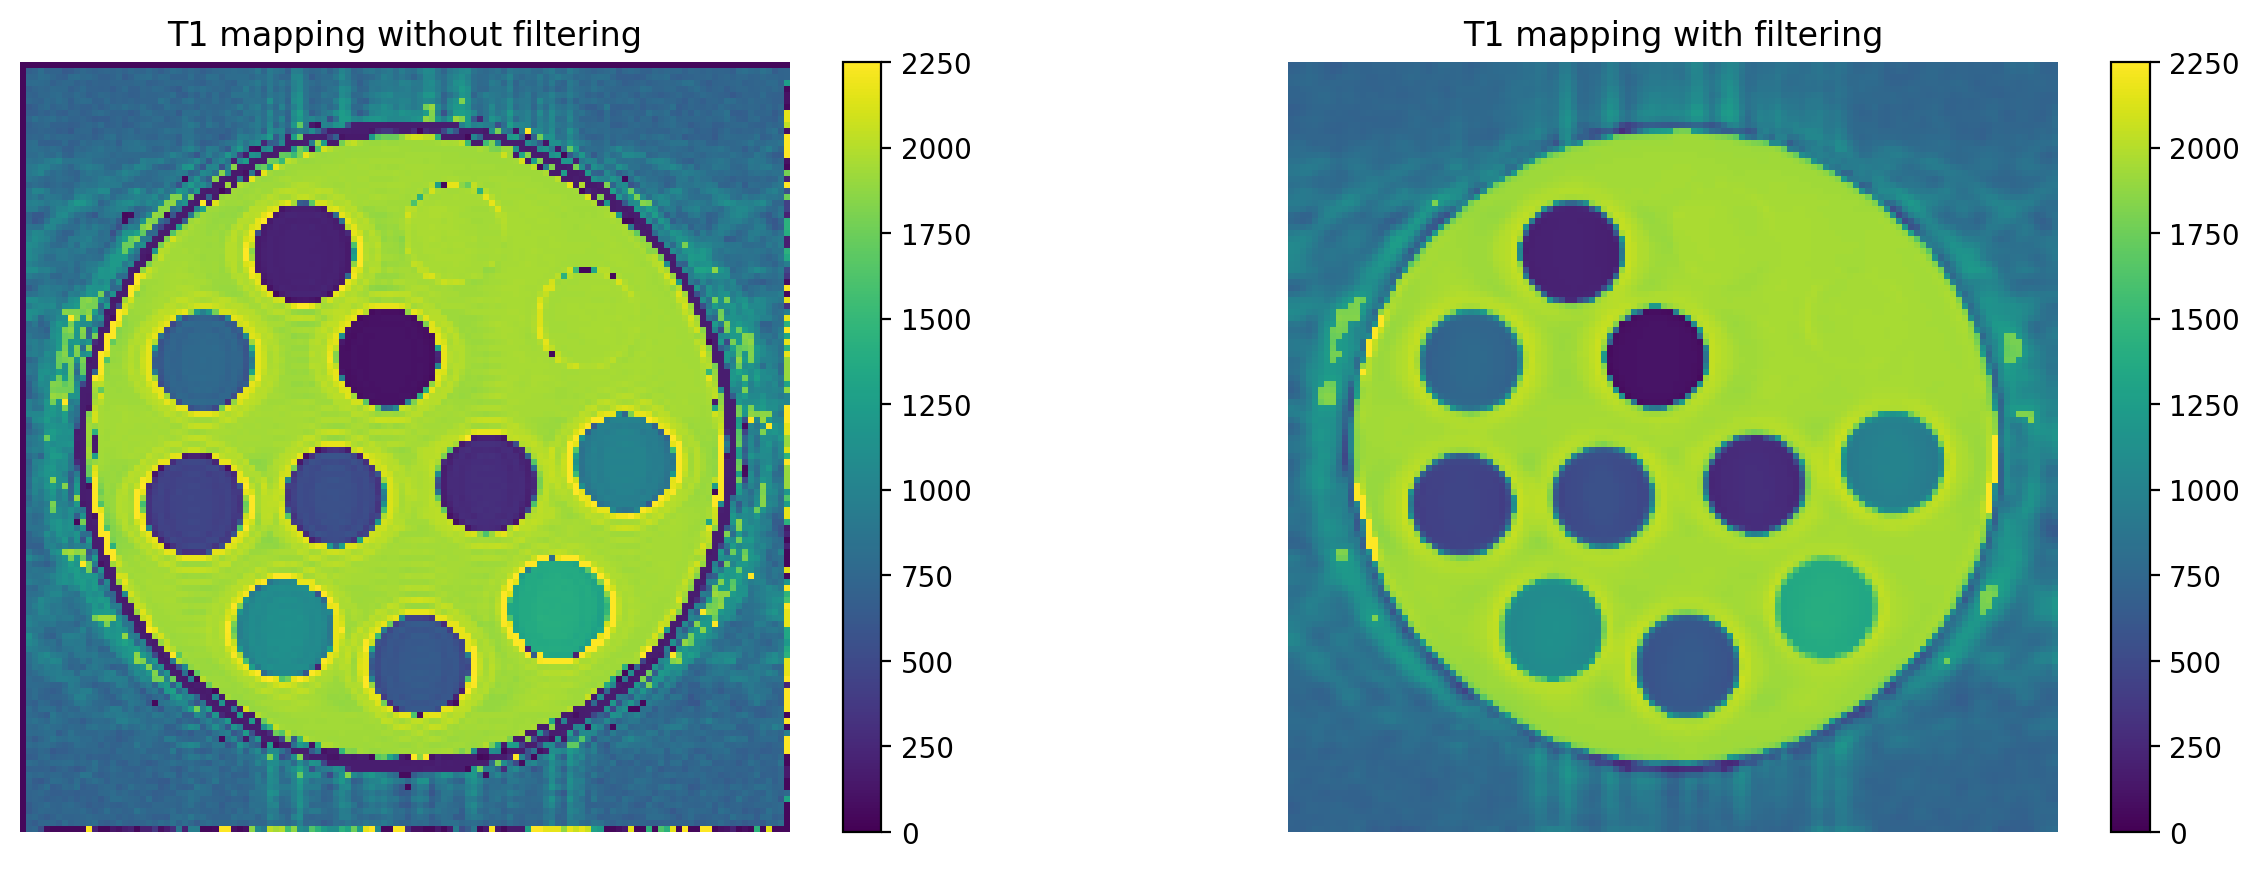

In [4]:
T1map_img_nofiltered = SVD_dict_fit(img_list, TI_list, T1_keys, T1_dict, preprocessed=False)
T1map_img_filtered = SVD_dict_fit(img_list, TI_list, T1_keys, T1_dict, preprocessed=True)
plt.figure(figsize=(15,5),dpi=200)
plt.subplot(1,2,1)
plt.imshow(T1map_img_nofiltered)
plt.title("T1 mapping without filtering")
plt.clim(0,2250)
plt.axis('off')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(T1map_img_filtered)
plt.title("T1 mapping with filtering")
plt.clim(0,2250)
plt.axis('off')
plt.colorbar()
plt.show()

## T2 star Mapping

dict size:  (10000,)


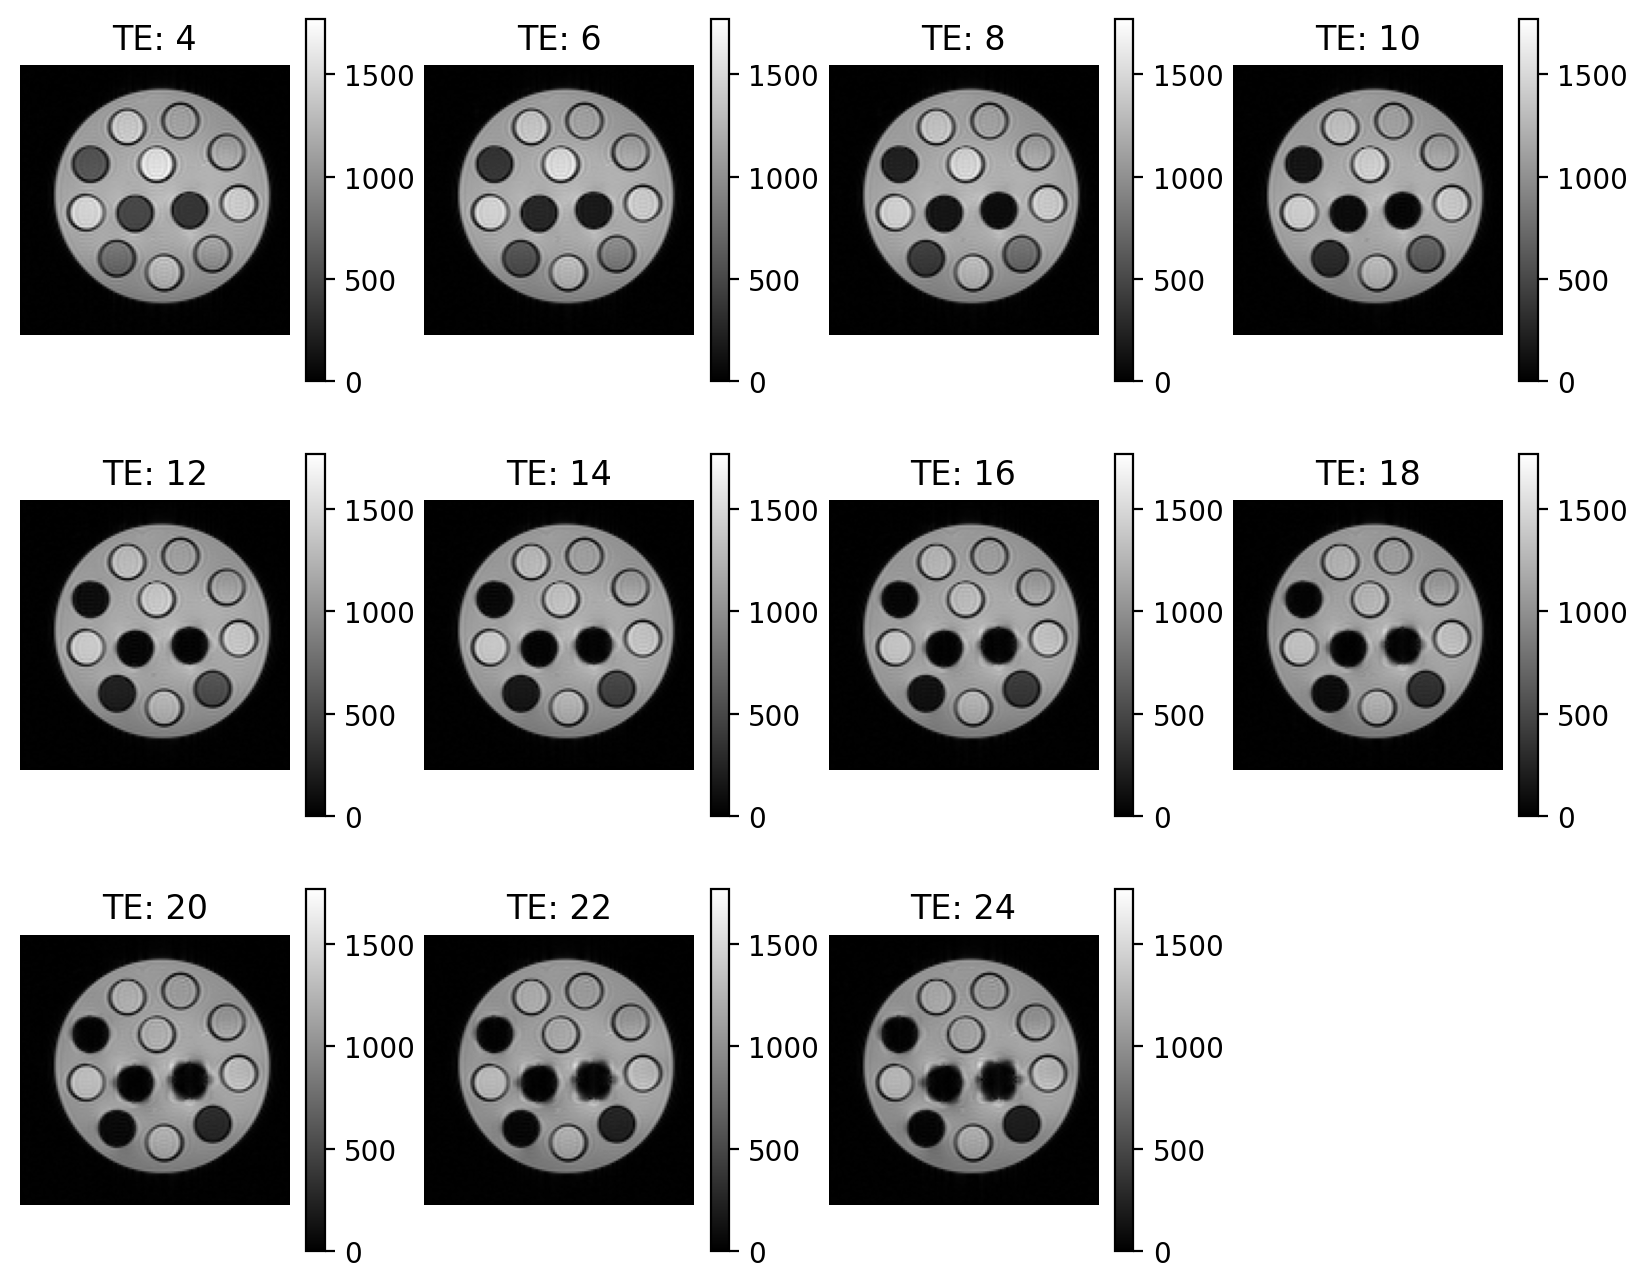

In [7]:
# Load T2 star data
data_path = "T2star"
TE_list = []
img_list = []
for data in os.listdir(data_path):
    if 'TE' in data:
        TE = int(data.split('_')[-1][2:-2])
        img = dcmread(os.path.join(data_path, data, '00001.dcm')).pixel_array
        TE_list.append(TE)
        img_list.append(img)
    
TE_list = np.asarray(TE_list)
img_list = np.asarray(img_list)
TE_list_idx = np.argsort(TE_list)
TE_list = TE_list[TE_list_idx]
img_list = img_list[TE_list_idx]

# Generate T2start dict
T2star_keys = np.arange(0.05, 500.05, 0.05)
print("dict size: ", T2star_keys.shape)

T2star_dict = []
for TE in TE_list:
    T2star_dict.append(np.abs((np.exp(-TE/T2star_keys))))

T2star_dict = np.asarray(T2star_dict).T

plt.figure(figsize=(10,8),dpi=200)
for i in range(11):
    plt.subplot(3,4,i+1)
    plt.imshow(img_list[i], cmap='gray')
    plt.clim(img_list.min(), img_list.max())
    plt.axis('off')
    plt.title("TE: "+str(TE_list[i]))
    plt.colorbar()

Eigen number:  4


C:\Users\HP\AppData\Local\Temp\ipykernel_12680\1330246560.py:24: RuntimeWarning: invalid value encountered in true_divide
  map = (img_flatten_k @ T1_dict_k.T*k_feature-np.outer(img_flatten_k.sum(axis=1),T1_dict_k.sum(axis=1)))/(np.sqrt(np.outer(k_feature*(img_flatten_k**2).sum(axis=1)-(img_flatten_k.sum(axis=1))**2,k_feature*(T1_dict_k**2).sum(axis=1)-(T1_dict_k.sum(axis=1))**2)))


Eigen number:  4


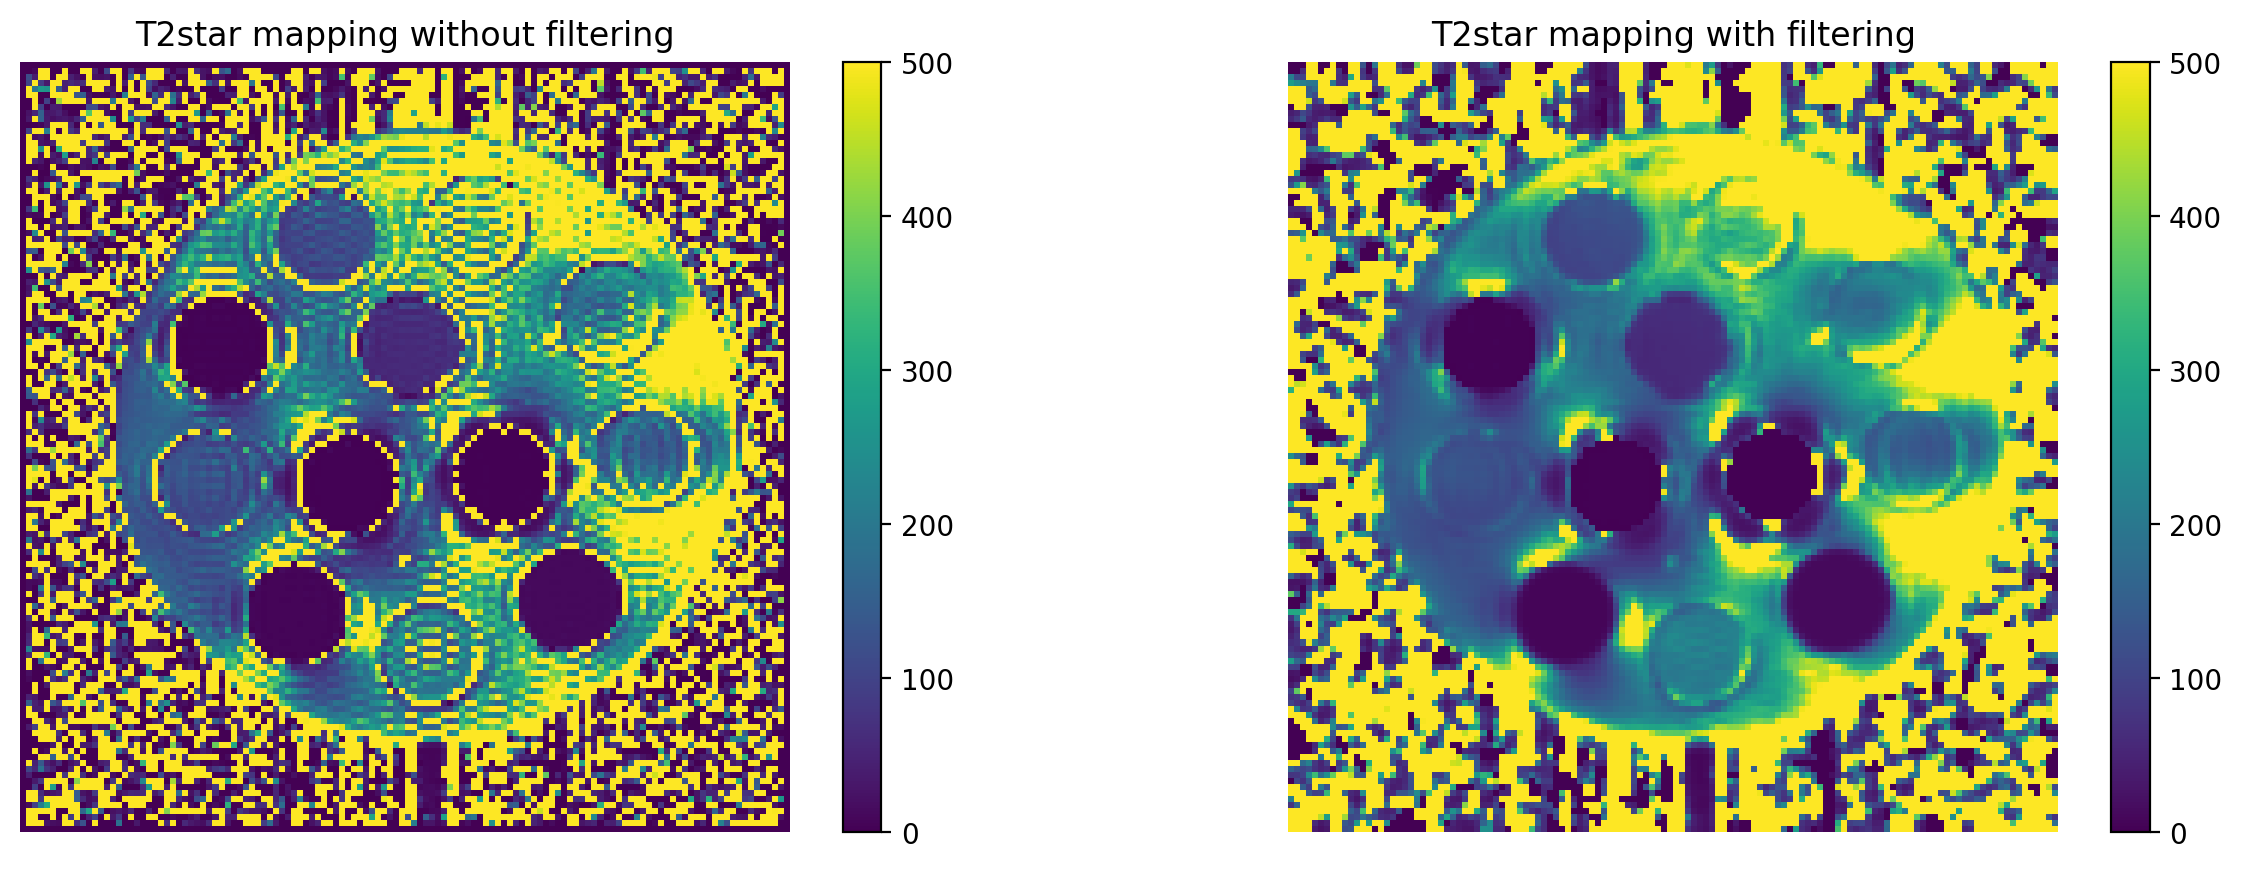

In [6]:
T2starmap_img_nofiltered = SVD_dict_fit(img_list, TE_list, T2star_keys, T2star_dict, preprocessed=False, threshold = 0.999)
T2starmap_img_filtered = SVD_dict_fit(img_list, TE_list, T2star_keys, T2star_dict, preprocessed=True, threshold = 0.999)
plt.figure(figsize=(15,5),dpi=200)
plt.subplot(1,2,1)
plt.imshow(T2starmap_img_nofiltered)
plt.title("T2star mapping without filtering")
plt.clim(0,500)
plt.axis('off')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(T2starmap_img_filtered)
plt.title("T2star mapping with filtering")
plt.clim(0,500)
plt.axis('off')
plt.colorbar()
plt.show()